## 2 Char RNN
<img src="assets/charseq.jpeg" width="500">

In [87]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [26]:
with open('tinyshakespeare.txt', 'r') as f:
    text=f.read()
vocab = sorted(set(text))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
encoded = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


In [30]:
def get_batches(arr, batch_size, n_steps):
    '''Create a generator that returns batches of size
       batch_size x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of characters per batch and number of batches we can make
    chars_per_batch = batch_size * n_steps
    n_batches = len(arr)//chars_per_batch
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * chars_per_batch]
    
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y_temp = arr[:, n+1:n+n_steps+1]
        
        # For the very last batch, y will be one character short at the end of 
        # the sequences which breaks things. To get around this, I'll make an 
        # array of the appropriate size first, of all zeros, then add the targets.
        # This will introduce a small artifact in the last batch, but it won't matter.
        y = np.zeros(x.shape, dtype=x.dtype)
        y[:,:y_temp.shape[1]] = y_temp
        
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [31]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`.

In [9]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32, [batch_size, num_steps], name='inputs')
    targets = tf.placeholder(tf.int32, [batch_size, num_steps], name='targets')
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs, targets, keep_prob

### LSTM Cell

Below, we implement the `build_lstm` function to create these LSTM cells and the initial state.

In [10]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    
    def build_cell(lstm_size, keep_prob):
        # Use a basic LSTM cell
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        return drop
    
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([build_cell(lstm_size, keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

### RNN Output


In [11]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        x: Input tensor
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # That is, the shape should be batch_size*num_steps rows by lstm_size columns
    seq_output = tf.concat(lstm_output, axis=1)
    x = tf.reshape(seq_output, [-1, in_size])
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size), stddev=0.1))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.matmul(x, softmax_w) + softmax_b
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits, name='predictions')
    
    return out, logits

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

In [12]:
def build_loss(logits, targets, lstm_size, num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    
    # One-hot encode targets and reshape to match logits, one row per batch_size per step
    y_one_hot = tf.one_hot(targets, num_classes)
    y_reshaped = tf.reshape(y_one_hot, logits.get_shape())
    
    # Softmax cross entropy loss
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped)
    loss = tf.reduce_mean(loss)
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [13]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 

In [14]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size, num_steps)

        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, num_layers, batch_size, self.keep_prob)

        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs, num_classes)
        
        # Run each sequence step through the RNN and collect the outputs
        outputs, state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss = build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

## Hyperparameters

Here I'm defining the hyperparameters for the network. 

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.


In [84]:
batch_size = 100        # Sequences per batch
num_steps = 100         # Number of sequence steps per batch
lstm_size = 512         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.001   # Learning rate
keep_prob = 0.4         # Dropout keep probability

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`

In [92]:
loss_list = []
epochs = 70
# Print losses every N interations
print_every_n = 50

# Save every N iterations
save_every_n = 200

model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):
            counter += 1
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            loss_list.append(batch_loss)
            if (counter % print_every_n == 0):
                end = time.time()
                print('Epoch: {}/{}... '.format(e+1, epochs),
                      'Training Step: {}... '.format(counter),
                      'Training loss: {:.4f}... '.format(batch_loss),
                      '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))

Epoch: 1/70...  Training Step: 50...  Training loss: 3.3029...  0.0820 sec/batch
Epoch: 1/70...  Training Step: 100...  Training loss: 3.1425...  0.0827 sec/batch
Epoch: 2/70...  Training Step: 150...  Training loss: 2.8108...  0.0835 sec/batch
Epoch: 2/70...  Training Step: 200...  Training loss: 2.5159...  0.0830 sec/batch
Epoch: 3/70...  Training Step: 250...  Training loss: 2.3770...  0.0822 sec/batch
Epoch: 3/70...  Training Step: 300...  Training loss: 2.3064...  0.0836 sec/batch
Epoch: 4/70...  Training Step: 350...  Training loss: 2.2198...  0.0836 sec/batch
Epoch: 4/70...  Training Step: 400...  Training loss: 2.1593...  0.0836 sec/batch
Epoch: 5/70...  Training Step: 450...  Training loss: 2.0832...  0.0852 sec/batch
Epoch: 5/70...  Training Step: 500...  Training loss: 2.0559...  0.0836 sec/batch
Epoch: 5/70...  Training Step: 550...  Training loss: 2.0097...  0.0853 sec/batch
Epoch: 6/70...  Training Step: 600...  Training loss: 1.9415...  0.0841 sec/batch
Epoch: 6/70...  T

Epoch: 45/70...  Training Step: 4950...  Training loss: 1.2459...  0.0849 sec/batch
Epoch: 46/70...  Training Step: 5000...  Training loss: 1.2644...  0.0854 sec/batch
Epoch: 46/70...  Training Step: 5050...  Training loss: 1.2725...  0.1098 sec/batch
Epoch: 46/70...  Training Step: 5100...  Training loss: 1.2837...  0.0861 sec/batch
Epoch: 47/70...  Training Step: 5150...  Training loss: 1.2707...  0.0850 sec/batch
Epoch: 47/70...  Training Step: 5200...  Training loss: 1.2625...  0.0864 sec/batch
Epoch: 48/70...  Training Step: 5250...  Training loss: 1.2805...  0.0859 sec/batch
Epoch: 48/70...  Training Step: 5300...  Training loss: 1.2573...  0.0844 sec/batch
Epoch: 49/70...  Training Step: 5350...  Training loss: 1.2609...  0.0853 sec/batch
Epoch: 49/70...  Training Step: 5400...  Training loss: 1.2502...  0.1016 sec/batch
Epoch: 50/70...  Training Step: 5450...  Training loss: 1.2449...  0.0901 sec/batch
Epoch: 50/70...  Training Step: 5500...  Training loss: 1.2394...  0.0862 se

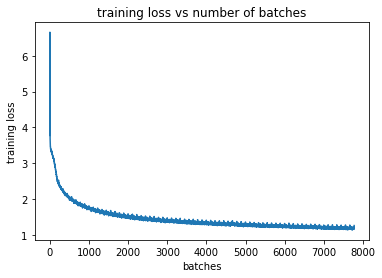

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_list)
plt.title('training loss vs number of batches')
plt.ylabel('training loss')
plt.xlabel('batches')
plt.show()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

## Sampling

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [96]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

In [97]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The "):
    samples = [c for c in prime]
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in prime:
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples)

Here, pass in the path to a checkpoint and sample from the network.

In [98]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/i7770_l512.ckpt'

In [99]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="All")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i7770_l512.ckpt
All thou hast dare thee so;
And which thou say'st the case of their parts to you
And shine as he had said in to the sun;
And some imposition will have browe,
And thou art not as send to say a wall:
There is no man shall buse the poor forting
But this all those that have a most of you
That I have spoke a torch and say at the
Asches and hath the power.

Provost:
Which I am stand. I am trust, then are
Teasing of you and serves, she will not be,
Which the poor husband shall be continuence
Of my son see the servings of the hour.
The more is now to stay the prayers are.

GLOUCESTER:
We have done, bear thee to my son and me
On my brave daughter: and I have so married
The case, and have a sorrow by the hundred,
To have a beart in this so tender done.
I say it, by your faith, and when you have
And that will speak where he dods speak to thee,
That's my distraying.

CORIOLANUS:
How now, my lord!

Second Murderer:
She, so I spea

In [100]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Lord")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i7770_l512.ckpt
Lord Capulet!

KING LEWIS XI:
The shepherd speaks well all, or shorted way,
The cause of this care of the provest tongue.
Who deness at her and mother there the man?

LADY CAPULET:
That is a winder side.

LEONTES:
O, that's no lank,
That take the weight of this are woes in sender.

KING RICHARD III:
It shall please my feeling of the day
And said I say; and tell me that thou hadst be so
To spright him friends;
What thou hast then to stable
The sea boy to thy sore, and heaven so stays:
This is a sight of me.

MARIANA:
Thou hast take them all.

SEBASTIAN:
I hope, she will.

COMINIUS:
The more I were a whell of any fair
Than they are special traitors all as wise.

LUCENTIO:
Ay, my good lary, to make the dispard.

KING RICHARD II:
A better troop, they should not creat your brother.

LADY ANNE:
Thou shalt not have the deadless doom of mercy,
Which he is so mine, which I do break a blessed
To her heavens but see, where I ma

In [101]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="MENE")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i7770_l512.ckpt
MENENIUS:
To be her subjects: I will brought me with a
Benting of me and to seak the fault,
And therein they was not to spide again.
What who is this?

GREMIO:
Nirse, sir, we have seen a pallief's patience.

GONZALO:
That is this track of mine of all this is true.

PETRUCHIO:
To her than speak; that's too. There is the son:
I am as many beating at thy sense.
What cause it who to him?

LEONTES:
He's a mercy:
The grief that stand with him. I have done thee.

PROSPERO:
I well deny to thine and that you can be.

KING RICHARD II:
And thou wilt live to me and most straight.

KING HENRY VI:
Ay, but the sea-shaped tears of mercy so.

BAPTISTA:
The duke is not in stop in this.

KING RICHARD II:
A poison of that hope to tell my father,
To spake my love to serve the self-bed stind
In stringing weight, betwixt his portion,
As with her blood, the care to hear thy sense,
That have been witted and before my best,
We are all the pro